In [1]:
import os
import gc
import random
import pickle

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

from scipy import stats
from scipy.stats import *


import warnings
warnings.filterwarnings("ignore")

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(42)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
PATH = "./ubiquant-market-prediction"
PRECISION = "half"
n_features = 300
FEATURES = [f'f_{i}' for i in range(n_features)]

In [4]:
if PRECISION == "half":
    train = pd.read_pickle(f'{PATH}/train.pkl')
else:
    train = pd.read_csv(f'{PATH}/train.csv')
    _ = train.pop("row_id")
    
time_id = train.pop("time_id")
investment_id = train.pop("investment_id")
y = train.pop("target")
    
train.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,0.114807,-2.013672,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,0.114807,-0.219238,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,0.114807,-1.035156,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,0.114807,-1.176758,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,0.114807,-0.005859,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [5]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls = 1e-2, lr = 1e-3):
    
    inp = tf.keras.layers.Input(shape = (num_columns, ))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, name = 'action')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = [decoder, out_ae, out])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                          'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls),
                          'action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls), 
                         },
                  metrics = {'decoder': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': tf.keras.metrics.AUC(name = 'AUC'), 
                             'action': tf.keras.metrics.AUC(name = 'AUC'), 
                            }, 
                 )
    
    return model

In [10]:
params = {'num_columns': len(FEATURES), 
          'num_labels': 1, 
          'hidden_units': [96, 96, 896, 448, 448, 256], 
          'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448], 
          'ls': 0, 
          'lr':1e-3, 
         }

In [13]:
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
def get_model():
#     investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
#     investment_id_x = investment_id_lookup_layer(investment_id_inputs)
#     investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
#     investment_id_x = layers.Reshape((-1, ))(investment_id_x)
#     investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
#     investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
#     investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
#     investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)

    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = feature_x #layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(8, activation='swish', kernel_regularizer="l2")(x)


    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
#     model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

In [15]:
model = get_model()

Epoch 1/50
2455/2455 [==============================] - 16s 4ms/step - loss: 0.9128 - mse: 0.8328 - mae: 0.6252 - mape: 116531.5625 - rmse: 0.9126 - val_loss: 0.8406 - val_mse: 0.8389 - val_mae: 0.6285 - val_mape: 189547.0938 - val_rmse: 0.9159
Epoch 2/50
2455/2455 [==============================] - 30s 12ms/step - loss: 0.8318 - mse: 0.8287 - mae: 0.6237 - mape: 138407.3594 - rmse: 0.9103 - val_loss: 0.8400 - val_mse: 0.8383 - val_mae: 0.6281 - val_mape: 205223.4375 - val_rmse: 0.9156
Epoch 3/50
2455/2455 [==============================] - 29s 12ms/step - loss: 0.8300 - mse: 0.8262 - mae: 0.6226 - mape: 147471.6094 - rmse: 0.9089 - val_loss: 0.8388 - val_mse: 0.8371 - val_mae: 0.6284 - val_mape: 192614.5469 - val_rmse: 0.9149
Epoch 4/50
2455/2455 [==============================] - 28s 12ms/step - loss: 0.8285 - mse: 0.8247 - mae: 0.6221 - mape: 154071.6406 - rmse: 0.9081 - val_loss: 0.8379 - val_mse: 0.8363 - val_mae: 0.6278 - val_mape: 181103.0781 - val_rmse: 0.9145
Epoch 5/50
2455/2

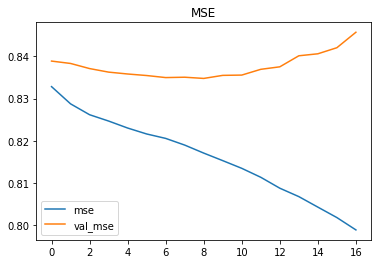

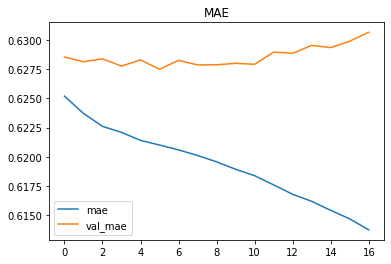

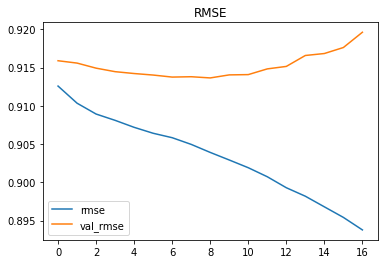

CPU times: user 11min 12s, sys: 1min 16s, total: 12min 28s
Wall time: 7min 51s


In [16]:
%%time
from sklearn.model_selection import StratifiedKFold, GroupKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break